## A Week 10 visualization problem. 

Load up the [Victoria PD Crime Report page](https://www.crimereports.com/agency/vicpdcanada) page. 

This page displays the crimes investigated by the Victoria Police Department over various time spans.  You can click on "Advanced Search" to set the crime types to display, and also the date ranges. 

If you click on "Show Details" you can download that page, it should give you a "CrimeReports.com Crime List.html" file and some other files in a subdirectory.  Notice that all the crime data is contained in the html file.  I have created a [simple application](scrape.CrimeReports.ipynb) that automates the process of gathering the data and storing it in a simple database. 

For this homework assignment we ask you to use data scraped from the Victoria PD Crime Report page and perform some (hopefully informative!) statistical analysis. 

The output for the data range from September 14th, 2015 until March 11th, 2016 is available in [this directory](dl.14.Sep.2015-11.Mar.2016.json.bz2) as a compressed json file.   This file gives a sampling of some analysis we could do.  At the end of the file will appear your homework assignment, to continue these visualizations. 


# Part 1

Let's pull the data from the json file. The data is stored on two lines, each one being a list of records.  One record is a dict-type object. 

In [1]:
import simplejson as json
from datetime import datetime, date

## you will likely need to install bzip2 to decompress dl.14.Sep.2015-11.Mar.2016.json.bz2
## sudo apt-get install bzip2
## the command "bunzip2 dl.14.Sep.2015-11.Mar.2016.json.bz2" will decompress the file.
f=open("dl.14.Sep.2015-11.Mar.2016.json", "r")
bigDat=[]
## the data appears in two lines, this is because the 2nd line
## data does not contain "Identifier" tag, it also does not contain
## a specific time for the event.  You will also notice a few
## records in bigDat[0] do not contain GPS coordinates. 
bigDat.append( json.loads(f.readline()) )
bigDat.append( json.loads(f.readline()) )
f.close()
print("bigDat[0] sample: ",bigDat[0][0], "\n\n", "bigDat[1] sample: ", bigDat[1][0])
print(len(bigDat[0]), len(bigDat[1]))
print(bigDat[0][0]['GPS'])
print(bigDat[0][0].keys())


ImportError: No module named simplejson

In [2]:
## now let's convert the text string "date" to proper dates, and gps coordinates to floats.
for i in range(2):
    for x in bigDat[i]:
        ## if i==0 we have a date/time field, and a gps field that needs conversion
        if 'GPS' in x: 
            x['GPS'][0] = float(x['GPS'][0])
            x['GPS'][1] = float(x['GPS'][1])
        ## if i==1 we have a date field and a geps field that needs conversion
        if i==0:
            x['Date/Time'] = datetime.strptime(x['Date/Time'], "%d-%b-%Y %I:%M %p") 
        if i==1:
            x['Date'] = datetime.strptime(x['Date'], "%d-%b-%Y").date()


## Part 2: basic analysis of the data. 

In [3]:
## returns the list of recorded crime types from the parsed list as argument
def recTypes(listRec):
    recT = set([])
    for R in listRec:
        recT.add(R['Crime Type'])
    recT = list(recT)
    return recT

## Let's break down the basic crime types. Take in a list of crimes, returns
## a dict (type, number).  So first lets create a set of all the crime types. 

def recCounts(listRec):
    recTyp = recTypes(listRec)
    counts = dict([(x,0) for x in recTyp])
    for R in listRec:
        counts[R['Crime Type']] += 1
    return counts

In [4]:
bigList = list(bigDat[0])
bigList.extend(bigDat[1])

In [5]:
breakD = recCounts(bigList)
print(breakD)
print("Total records: ", len(bigList))

{'Theft': 1426, 'Disorder': 180, 'Breaking & Entering': 329, 'Weapons Offense': 61, 'Traffic': 1614, 'Assault with Deadly Weapon': 128, 'Assault': 49, 'Alarm': 106, 'Vehicle Stop': 260, 'Drugs': 226, 'Robbery': 59, 'Liquor': 724, 'Theft of Vehicle': 120, 'Property Crime': 582, 'Other': 1724, 'Community Policing': 2, 'Theft from Vehicle': 600, 'Arson': 18, 'Pedestrian Stop': 446}
Total records:  8654


In [6]:
## Let's create a pie chart 
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib nbagg

tot = len(bigList)
cTypes = [k for k,v in breakD.items()]
fractions = [100*v/tot for k,v in breakD.items()]

## re-arrange the order to make a more pleasant plot
sortme = [(cTypes[i], fractions[i]) for i in range(len(cTypes))]
import operator
sortme.sort(key=operator.itemgetter(1))
newlist = []
count=0
while len(sortme)>0:
    if count % 2 == 1: 
        newlist.append(sortme[0])
        sortme.pop(0)
    else:
        newlist.append(sortme[-1])
        sortme.pop()
    count+=1

fractions = [newlist[i][1] for i in range(len(newlist))]
cTypes = [newlist[i][0] for i in range(len(newlist))]



<IPython.core.display.Javascript object>


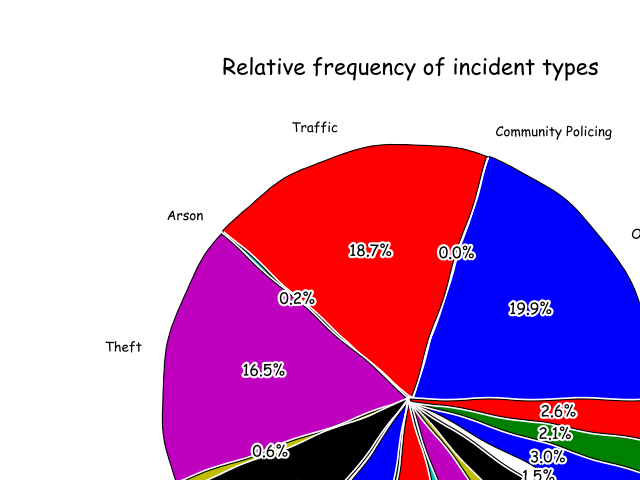

In [7]:
with plt.xkcd(): ## this enables the xkcd style.
    
    fig=plt.figure()
    fig.set_size_inches(10,10) 
    
    #pushOut = (0,0.1,0,0) ##
    
    ## explode is the push-out parameter.  labels are the text around the
    ## circumference.  autopct puts the percentage in the pie slices. 
    ## shadow adds a bit of depth to the image.
    plt.pie(fractions, labels=cTypes, autopct='%1.1f%%', shadow=False)
    ## shadow=True / False
    plt.title('Relative frequency of incident types', fontsize=20)
    


## Part 3: some more sophisticated data analysis


In [11]:
## Let's break the above data base up by the days of the week. Monday 0 through Sunday 6.
weekArr = [[],[],[],[],[],[],[]]
for x in bigList:
    ## check if has Date field or Date/Time field
    if 'Date/Time' in x:
        weekArr[x['Date/Time'].weekday()].append(x)
    else:
        weekArr[x['Date'].weekday()].append(x)
for x in weekArr:
    print(len(x))
    

1148
1232
1216
1238
1353
1291
1176


In [12]:
## oh, we should be careful.  How many mondays are in our date range, etc? 
from datetime import date
weekDays = [set(),set(),set(),set(),set(),set(),set()]
for x in bigList:
    if 'Date/Time' in x:
        weekDays[x['Date/Time'].weekday()].add(x['Date/Time'].date())
    else:
        weekDays[x['Date'].weekday()].add(x['Date'])

In [13]:
for i in range(7):
    print(i, len(weekDays[i]))

0 26
1 26
2 26
3 26
4 26
5 25
6 25


In [14]:
## So we can compute the average number of crimes per weekday
avgArr=[]
for i in range(7):
    avgArr.append(len(weekArr[i])/len(weekDays[i]))

In [15]:
weekNames=['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
## Let's write out the weekdays by how bad the crime rates are.
sortme = [(i, avgArr[i]) for i in range(len(avgArr))]
sortme.sort(key=operator.itemgetter(1))
print(sortme)
print("The days of the week in order of ascending crime rates: ")
for x in sortme:
    print(weekNames[x[0]], " -> ", x[1])

[(0, 44.15384615384615), (2, 46.76923076923077), (6, 47.04), (1, 47.38461538461539), (3, 47.61538461538461), (5, 51.64), (4, 52.03846153846154)]
The days of the week in order of ascending crime rates: 
Monday  ->  44.15384615384615
Wednesday  ->  46.76923076923077
Sunday  ->  47.04
Tuesday  ->  47.38461538461539
Thursday  ->  47.61538461538461
Saturday  ->  51.64
Friday  ->  52.03846153846154


In [16]:
count = 0
for x in bigList:
    if 'GPS' not in x:
        count += 1
print(count, len(bigList))
## one in 40 records missing GPS coordinates. 
## we could write a routine to put those in, or just ignore these records for now.

208 8654


## Basic heat map 

In [17]:
print(recTypes(bigList))

['Theft', 'Disorder', 'Breaking & Entering', 'Theft from Vehicle', 'Weapons Offense', 'Robbery', 'Traffic', 'Assault with Deadly Weapon', 'Alarm', 'Vehicle Stop', 'Drugs', 'Liquor', 'Assault', 'Theft of Vehicle', 'Property Crime', 'Other', 'Community Policing', 'Arson', 'Pedestrian Stop']


In [18]:
## Heatmap, of Assault with a Deadly Weapon. 
import folium
from folium import plugins

import numpy as np

## data needs to be a list [x,y,z] [x,y] the gps coordinates and z the "heat"
## so let's run through the GPS coordinates, and build this list and decide on what
## the "heat" should be. 
data = []
for x in bigList:
    if ('GPS' in x) and (x['Crime Type']=="Assault with Deadly Weapon"):
        newpt = [x['GPS'][0], x['GPS'][1], 0.02 ]
        ## decide on "heat"
        data.append( newpt )
mapa = folium.Map([48.4323, -123.3720], tiles='Stamen Terrain', zoom_start=13)
mapa.add_children(plugins.HeatMap(data))
#mapa.create_map(path='awdw.heatmap.html')
mapa

In [19]:
## Heatmap, drugs on Fridays
data = []
for x in bigList:
    if ('GPS' in x) and (x['Crime Type']=="Alarm"):
        ## plot Drugs on Fridays...
        if (('Date/Time' in x) and (x['Date/Time'].weekday()==4)) or \
           (('Date' in x) and (x['Date'].weekday()==4)):
            newpt = [x['GPS'][0], x['GPS'][1], 0.1 ]
            data.append( newpt )
            
mapa = folium.Map([48.4323, -123.3720], tiles='OpenStreetMap', zoom_start=13)
mapa.add_children(plugins.HeatMap(data))
#mapa.create_map(path='awdw.heatmap.html')
mapa

In [20]:
# Let's make a stacked bar chart indicating crime types by weekday

ctypes = recTypes(bigList) ## string rep crime type names
arrCount = np.zeros( (len(ctypes), len(weekNames)) )
for x in bigList:
    if 'Date' in x:
        wN = x['Date'].weekday()
    elif 'Date/Time' in x:
        wN = x['Date/Time'].weekday()
    arrCount[next(k for k in range(len(ctypes)) if ctypes[k]==x['Crime Type']), wN]+=1
## arrCount[i] is the crime counts by weekday for ctypes[i]

## matrix of partial sums
psum = np.zeros( (len(ctypes), len(weekNames)) )
for j in range(len(weekNames)):
    for i in range(len(ctypes)):
        ## psum[i,j] = psum[i,j-1] + arrCount[i,j]
        if i==0: psum[i,j] = 0
        else: psum[i,j] = psum[i-1,j] + arrCount[i-1,j]

print(arrCount[0], arrCount[1])
print(psum[0], psum[1])

[ 206.  251.  190.  208.  214.  176.  181.] [ 17.  27.  20.  27.  25.  30.  34.]
[ 0.  0.  0.  0.  0.  0.  0.] [ 206.  251.  190.  208.  214.  176.  181.]


<IPython.core.display.Javascript object>


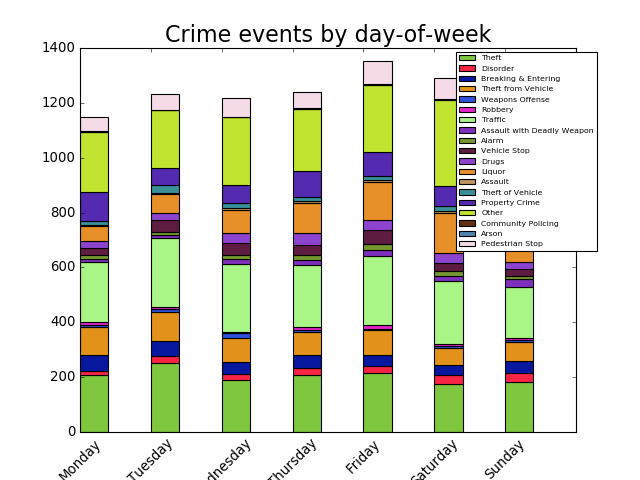

In [21]:
%matplotlib nbagg

colarr = [np.random.rand(3,1) for i in range(len(ctypes))]

import matplotlib.pyplot as plt
fig = plt.figure() ## get the figure-object for our plot.

width = 0.4
xc = list(range(len(weekNames)))
p = [] ## plot array

for i in range(len(ctypes)):
    if i==0:
        p.append( plt.bar(xc, arrCount[i].tolist(), width, color=colarr[i] ) )
    else:
        p.append( plt.bar(xc, arrCount[i].tolist(), width, color=colarr[i], bottom=psum[i]) )

ax1 = plt.subplot(111)
plt.xticks(xc, weekNames, rotation=45)
#ax1.set_xticklabels( xc, rotation=45 )
plt.title('Crime events by day-of-week', fontsize=20)

ax1.legend(p, ctypes, prop={'size':7}, bbox_to_anchor=(1.05,1.0))
        
plt.show()

After some correspondence with the Victoria Police Department IT office, they let me know some details on what the "Crime Types" mean:

* Disorder – Cause a Disturbance
 
* Assault with a weapon – Aggravated or Weapon Assaults which includes Assault - Cause Bodily Harm. 
 
* Alarms - False Alarms
 
* Vehicles stop – Vehicle impounds  
 
* Drugs – Drug Possession, Trafficking, Import/Exports, Production
 
* Weapon Offence – Weapon Possessions, Trafficking, including unauthorized transportation and pointing of a firearm
 
* Pedestrian stop – situations where officers have spoken to cyclists or pedestrians, i.e. – cyclist not wearing a bicycle helmet    
 
* Break and Entering – inclusive of both residence and business break and enters
 
* Theft of vehicle – Thefts of all motorized vehicles
 
* Other – Obstructions, Animal calls, Noise Bylaw, Impersonations and Suspicious vehicles/persons/occurrences
 
* Theft – Thefts over and under $5,000 excluding theft of or from motor vehicles
 
* Assault – Common assaults
 
* Property Crime – Mischiefs, Possession stolen property and some Frauds
 
* Traffic – Provincial and Criminal code traffic offences, motor vehicle collisions, and driving complaints
 
* Liquor – Liquor act offences
 
* Incidents where an individual is charged and found accountable for the incident indicate “concluded” on them. 
 
* The GPS coordinates and address information is only an “approximate” location and in no way pinpoints the exact location of where an incident occurred.  An individual can report lost property to an officer at the VicPD Police Headquarters building at 850 Caledonia Avenue.  The approximate location will be the 800 block of Caledonia Avenue even though the property may have been lost in the downtown vicinity however, the exact location is unknown. 
  
 

In [22]:
#print(breakD)
srt_bD = sorted(breakD.items(), key=operator.itemgetter(1))
topCrimes = srt_bD[10:]
smlCrimes = srt_bD[:10]
## let's convert arrCount to a dict-type object, indexed by the crime type
darrcount = dict()
for i in range(len(ctypes)):
    darrcount[ctypes[i]] = arrCount[i]
print(topCrimes)
topCrimes=dict(topCrimes)
smlCrimes=dict(smlCrimes)
allCrimes=dict(srt_bD)

[('Vehicle Stop', 260), ('Breaking & Entering', 329), ('Pedestrian Stop', 446), ('Property Crime', 582), ('Theft from Vehicle', 600), ('Liquor', 724), ('Theft', 1426), ('Traffic', 1614), ('Other', 1724)]


<IPython.core.display.Javascript object>


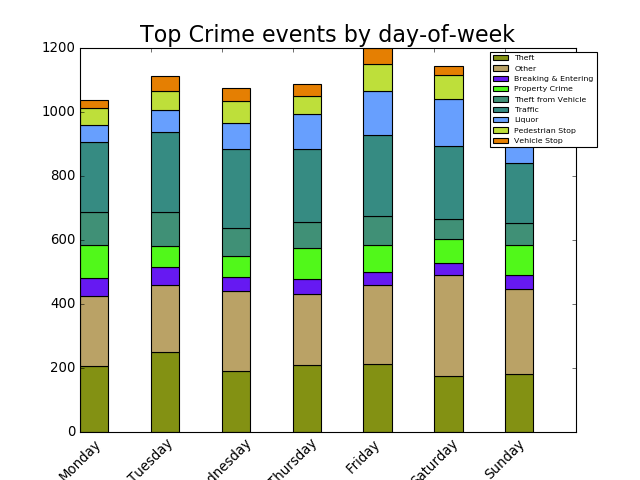

In [23]:
## Most common crime stacked bar chart

colarr = dict([(x, np.random.rand(3,1)) for x,v in topCrimes.items()])

fig = plt.figure() ## get the figure-object for our plot.
width = 0.4
xc = list(range(len(weekNames)))
p = [] ## plot array
psum = np.zeros( len(weekNames) ) ## partial sums for bottom of bars

for i,j in topCrimes.items():
    p.append( plt.bar(xc, darrcount[i].tolist(), width, color=colarr[i], bottom=psum.tolist()) )
    ## update psum
    for k in range(len(psum)):
        psum[k] += darrcount[i][k]
    
ax1 = plt.subplot(111)
plt.xticks(xc, weekNames, rotation=45)
plt.title('Top Crime events by day-of-week', fontsize=20)
ax1.legend(p, list(topCrimes.keys()), prop={'size':7}, bbox_to_anchor=(1.05,1.0))
        
plt.show()

<IPython.core.display.Javascript object>


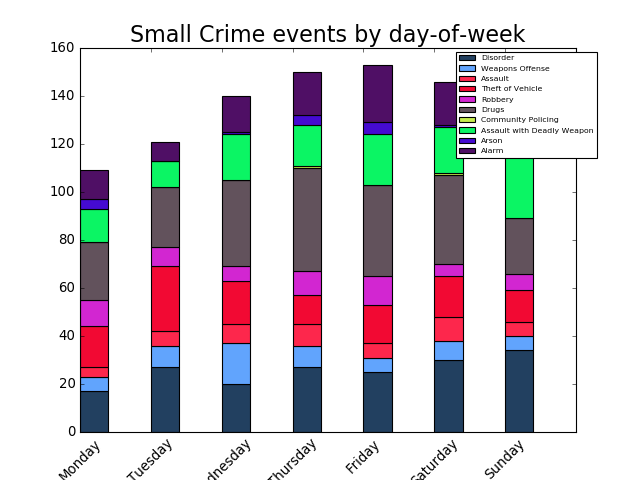

In [24]:
colarr = dict([(x, np.random.rand(3,1)) for x,v in smlCrimes.items()])

fig = plt.figure() ## get the figure-object for our plot.
width = 0.4
xc = list(range(len(weekNames)))
p = [] ## plot array
psum = np.zeros( len(weekNames) ) ## partial sums for bottom of bars

for i,j in smlCrimes.items():
    p.append( plt.bar(xc, darrcount[i].tolist(), width, color=colarr[i], bottom=psum.tolist()) )
    ## update psum
    for k in range(len(psum)):
        psum[k] += darrcount[i][k]
 
ax1 = plt.subplot(111)
plt.xticks(xc, weekNames, rotation=45)
plt.title('Small Crime events by day-of-week', fontsize=20)
ax1.legend(p, list(smlCrimes.keys()), prop={'size':7}, bbox_to_anchor=(1.05,1.0))
        
plt.show()

In [25]:
## find the first and last dates in our database
dateset = set()
for x in bigList:
    if 'Date' in x:
        dateset.add(x['Date'])
    elif 'Date/Time' in x:
        x['Date'] = x['Date/Time'].date()
        dateset.add(x['Date/Time'].date())

sorteddates = sorted(dateset)
numdays = (sorteddates[-1]-sorteddates[0]).days + 1
## Let's check for crime types with a lot of variation, vs. ones that have little. 
##  we can do it weekday by weekday, and also day-to-day. 
c_daily = dict()
for x in ctypes:
    c_daily[x] = np.zeros(numdays)
for x in bigList:
    c_daily[x['Crime Type']][(x['Date']-sorteddates[0]).days] += 1


<IPython.core.display.Javascript object>


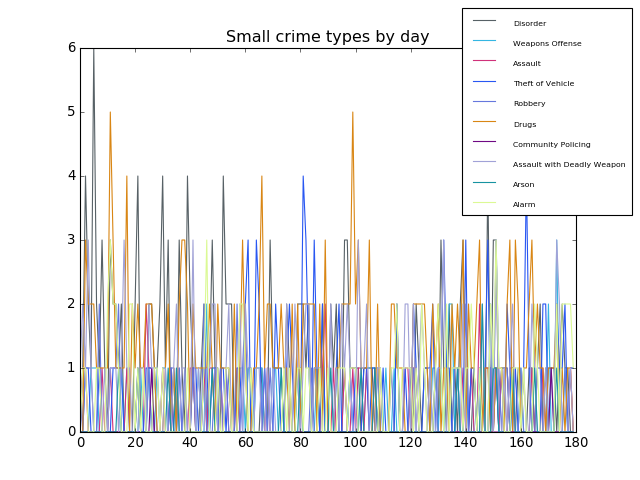

[None, None, None, None, None, None, None, None, None, None]

In [26]:
fig = plt.figure() ## get the figure-object for our plot.
for i,j in smlCrimes.items():
    plt.plot( np.arange(0, numdays), c_daily[i], color=np.random.rand(3,1),
                          label=i)  
plt.title("Small crime types by day")
plt.legend(bbox_to_anchor=(1.0,1.0), bbox_transform=plt.gcf().transFigure)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='7')
## day-by-day count, by crime type. 
## we need to find the earliest date, and record our "count" vectors indexed off that
##  first date

<IPython.core.display.Javascript object>


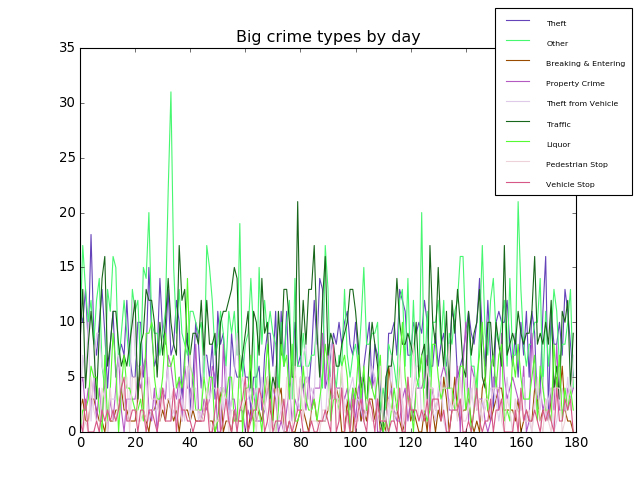

[None, None, None, None, None, None, None, None, None]

In [27]:
fig = plt.figure() ## get the figure-object for our plot.
for i,j in topCrimes.items():
    plt.plot( np.arange(0, numdays), c_daily[i], color=np.random.rand(3,1),
             label=i )
plt.title("Big crime types by day")
plt.legend(bbox_to_anchor=(1.0,1.0), bbox_transform=plt.gcf().transFigure)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='7')

In [28]:
#fig=plt.figure()
## plot daily occurences against each other... 
#plt.plot( c_daily['Liquor'], c_daily['Pedestrian Stop'], 'ro')
#plt.plot( c_daily['Other'], c_daily['Property Crime'], 'bo')

# ['Arson', 'Community Policing', 'Robbery', 'Liquor', 'Property Crime', 'Traffic', 'Disorder', 
# 'Theft from Vehicle', 'Pedestrian Stop', 'Drugs', 'Assault', 'Theft', 'Other', 'Weapons Offense',
# 'Breaking & Entering', 'Vehicle Stop', 'Theft of Vehicle', 'Assault with Deadly Weapon', 
# 'Alarm']

In [29]:
print(type(c_daily['Theft']))
print(c_daily['Theft'].shape)
print(sum(c_daily['Theft'])/len(c_daily['Theft']))

<class 'numpy.ndarray'>
(180,)
7.92222222222


PCA components: 
 [[ 0.00809157  0.99996726]
 [ 0.99996726 -0.00809157]] 

Magnitude of PCA components: 
 [ 2.80174936  1.11417123]


/usr/local/lib/python3.4/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


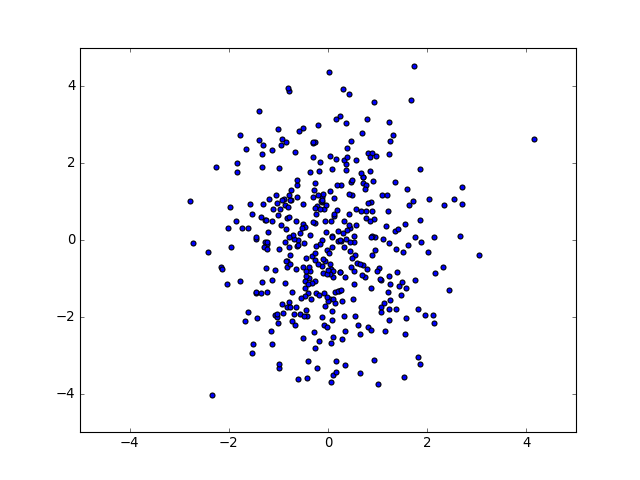

In [68]:
## These plots are too difficult to interpret.  Let's do a PCA (Principle Component Analysis)
## to see what kind of linear relationships there is in the data. 

from sklearn.decomposition import PCA

## first let's have a little demo of what PCA does. 

from numpy.random import multivariate_normal
mvn = multivariate_normal( [0,0], [[1,0], [0,3]], 400 )
pca = PCA(n_components=2)
pca.fit(mvn)
print("PCA components: \n",pca.components_, "\n")
print("Magnitude of PCA components: \n",pca.explained_variance_)

fig = plt.figure()
plt.axis([-5,5,-5,5])
plt.scatter(*zip(*mvn))

## as you can sort of see from this analysis, PCA takes data and asks to what extent
## it looks like a multivariate normal distribution, i.e. if the data appears to be
## clustering in an ellipsoidal blob. The algorithm finds the axis of the ellipsoid as 
## well as a rough measure for how long each axis is. 

Let's buidl a matrix whose rows represent an individual day, and the columns count crimes, by "Crime Type". 

In [69]:
## so I need to build it so that c_daily[i] is a column. 
ctypelist = list(ctypes)
X=np.empty( (numdays, len(ctypes)) )
for j in range(len(ctypelist)):
    #avg_j = sum(c_daily[ctypelist[j]]) / len(c_daily[ctypelist[j]])
    # subtracting off the averages does nothing.  nice. 
    for i in range(numdays):
        X[i,j] = c_daily[ctypelist[j]][i] # - avg_j

pca = PCA(n_components=len(ctypes))
pca.fit(X)
print("Magnitude of PCA components:\n",pca.explained_variance_)
## let's write some code to pull-out the indices of the largest elements in the 
## PCA components so we can know what ctypes they correspond to
## Top two:

## returns the i most correlated crime types at stage k of the PCA
def mostCorr(k, i):
    abspcav = np.abs(pca.components_[k])
    TT = sorted(abspcav)[-i:]
    ctl = []
    for x in TT:
        ctl.append(list(abspcav).index(x))
    retval = [ [pca.components_[k][ctl[j]], ctypelist[ctl[j]]] for j in range(i)]
    return retval

## routine runs through PCA data and determines inverse corellations
## at stage k.
def determineTradeOffs(k):
    X = mostCorr(k, len(ctypes))
    P = []; N = [];
    for x in X:
        if x[0]>0 and abs(x[0])>0.01:
            P.append(x)
        elif x[0]<0 and abs(x[0])>0.01:
            N.append(x)
    P = sorted(P, key=operator.itemgetter(0), reverse=True)
    N = sorted(N, key=operator.itemgetter(0))
    return P, N

for k in range(8):
    print("\nAt stage ", k, " eigval %.3f" % pca.explained_variance_ratio_[k], " there is an inverse corellation between: \n")
    P, N = determineTradeOffs(k)
    for w in P:
        print(" %.1f" % (w[0]*100), "% ", w[1], "\n", end="")
    print("and")
    for w in N:
        print(" %.1f" % (-w[0]*100), "% ", w[1], "\n", end="")

Magnitude of PCA components:
 [  1.86690916e+01   1.19146886e+01   9.70793870e+00   6.20822355e+00
   4.61634034e+00   3.97599700e+00   3.10230645e+00   1.87950963e+00
   1.74346327e+00   1.14834571e+00   9.16573280e-01   7.72090973e-01
   6.20515847e-01   5.47232364e-01   3.18039892e-01   2.66850263e-01
   2.01864838e-01   8.24973765e-02   1.05290947e-02]

At stage  0  eigval 0.280  there is an inverse corellation between: 

 8.6 %  Theft from Vehicle 
 3.0 %  Theft of Vehicle 
and
 95.1 %  Other 
 27.7 %  Liquor 
 5.7 %  Property Crime 
 5.3 %  Traffic 
 5.1 %  Theft 
 2.8 %  Assault with Deadly Weapon 
 2.1 %  Pedestrian Stop 
 1.9 %  Drugs 
 1.9 %  Assault 
 1.2 %  Vehicle Stop 
 1.2 %  Disorder 
 1.1 %  Alarm 
 1.1 %  Breaking & Entering 

At stage  1  eigval 0.179  there is an inverse corellation between: 

 97.1 %  Traffic 
 17.8 %  Theft 
 9.4 %  Theft from Vehicle 
 6.5 %  Property Crime 
 5.5 %  Drugs 
 2.5 %  Disorder 
 1.8 %  Theft of Vehicle 
and
 5.9 %  Pedestrian Stop 
 

In [31]:
## Let's try a heatmap to see if we can spatially separate some of the above apparent
## trade-offs in crimes above. 

data1 = []
for x in bigList:
    if ('GPS' in x) and (x['Crime Type']=="Liquor") and (x['Date'].weekday() == 4):
        newpt = [x['GPS'][0], x['GPS'][1], 0.1 ]
        data1.append( newpt )
        
data2 = []
for x in bigList:
    if ('GPS' in x) and (x['Crime Type']=="Theft from Vehicle") and (x['Date'].weekday() == 4):
        newpt = [x['GPS'][0], x['GPS'][1], 0.1 ]
        data2.append( newpt )

            
mapa = folium.Map([48.4323, -123.3720], tiles='OpenStreetMap', zoom_start=13)
mapa.add_children(plugins.HeatMap(data1, gradient={0.3: 'yellow', 0.5: 'lime', 0.6:'green'}))
mapa.add_children(plugins.HeatMap(data2, gradient={0.3: 'pink', 0.5: 'orange', 0.6: 'red'}))
#mapa.create_map(path='awdw.heatmap.html')
mapa

In [32]:
## Hmm, not finding much spatial separation.  Let's look for temporal separation, by
## hour of the day.  Let's plot two crime times, a histogram by time of day, in a
## polar bar chart. 

## dict of key crime type, value np.array with 24 entries (hour of day), count number of events.
timeBar = dict()
for c in ctypes:
    timeBar[c] = np.zeros(24)
for x in bigList:
    if 'Date/Time' in x:
        timeBar[x['Crime Type']][x['Date/Time'].hour] += 1

<IPython.core.display.Javascript object>


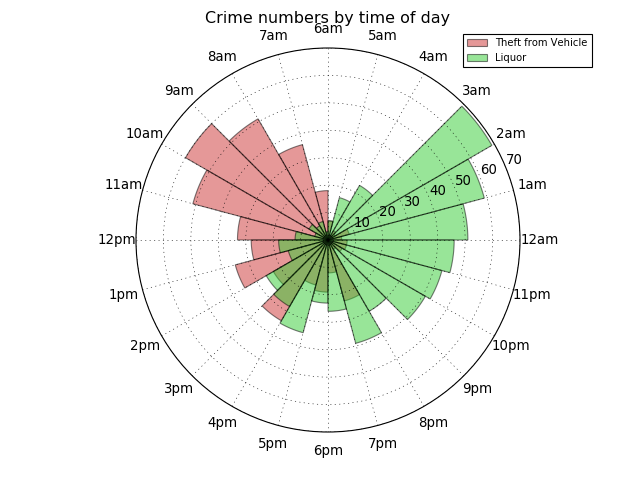

In [33]:
def crimeCountTime(ct1, ct2):
    fig = plt.figure()
    T = np.linspace(0.0, 2*np.pi, 24, endpoint=False)

    radii1 = timeBar[ct1]
    radii2 = timeBar[ct2]
    width = (2*np.pi/24)*np.ones(24)

    ax = plt.subplot(111, projection='polar')

    ax.set_xticks(np.linspace(0.0,2*np.pi, 24, endpoint=False))
    ticklab = [i % 12 for i in range(24)]; ticklab[0] = 12; ticklab[12]=12;
    ticklab = [str(x) for x in ticklab]; 
    for i in range(24):
        if (i<12): ticklab[i] = ticklab[i]+"am"
        else: ticklab[i] = ticklab[i]+"pm"
        
    ax.set_xticklabels(ticklab)

    bars1 = ax.bar(T, radii1, width=width, bottom=0.0)
    bars2 = ax.bar(T, radii2, width=width, bottom=0.0)

    for r, bar in zip(radii1, bars1):
        bar.set_alpha(0.5)
        bar.set_facecolor([0.8,0.2,0.2])
    for r, bar in zip(radii2, bars2):
        bar.set_alpha(0.5)
        bar.set_facecolor([0.2,0.8,0.2])
    plt.title("Crime numbers by time of day")
    ax.legend([bars1,bars2], [ct1, ct2], prop={'size':9}, bbox_to_anchor=(1.2,1.05))

crimeCountTime('Theft from Vehicle', 'Liquor')

<IPython.core.display.Javascript object>


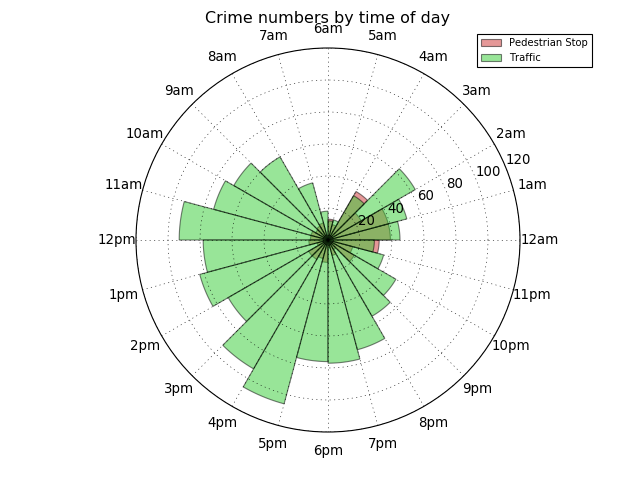

In [34]:
crimeCountTime('Pedestrian Stop', 'Traffic')

<IPython.core.display.Javascript object>


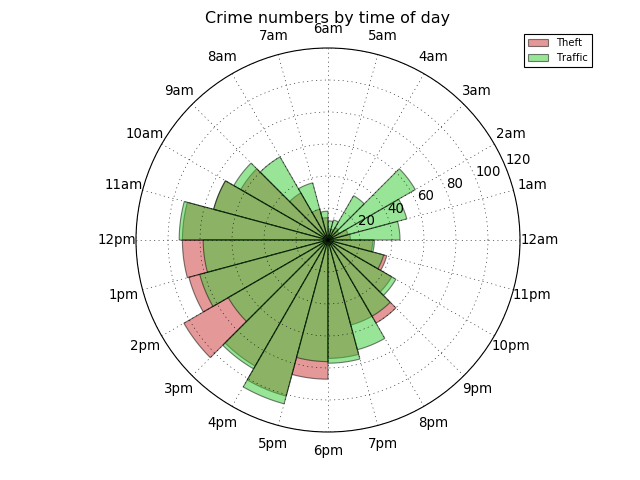

In [35]:
crimeCountTime('Theft', 'Traffic')

<IPython.core.display.Javascript object>


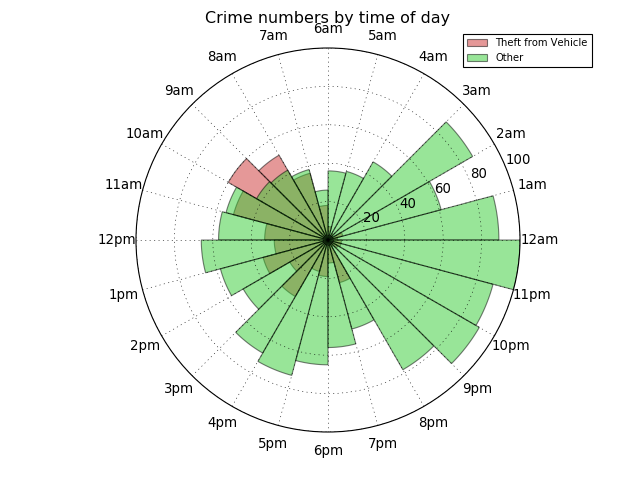

In [36]:
crimeCountTime('Theft from Vehicle', 'Other')

<IPython.core.display.Javascript object>


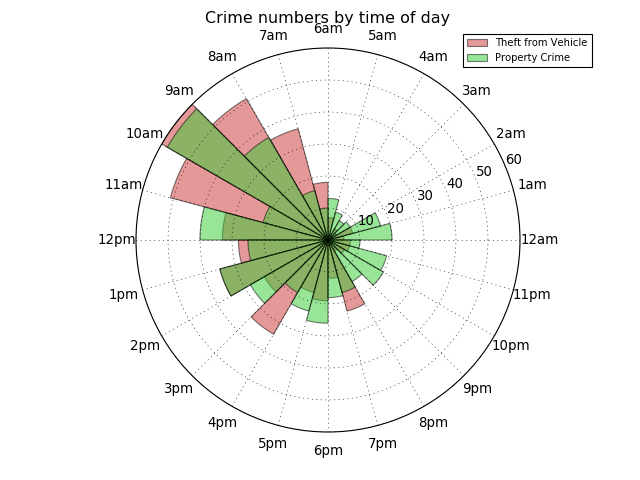

In [37]:
crimeCountTime('Theft from Vehicle', 'Property Crime')

<IPython.core.display.Javascript object>


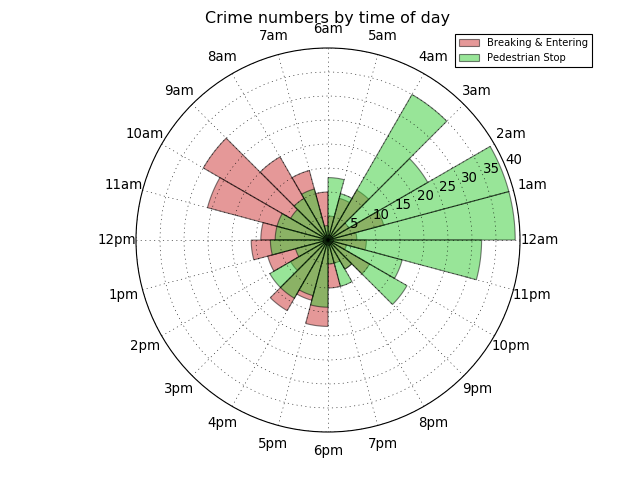

In [38]:
crimeCountTime('Breaking & Entering', 'Pedestrian Stop')

<IPython.core.display.Javascript object>


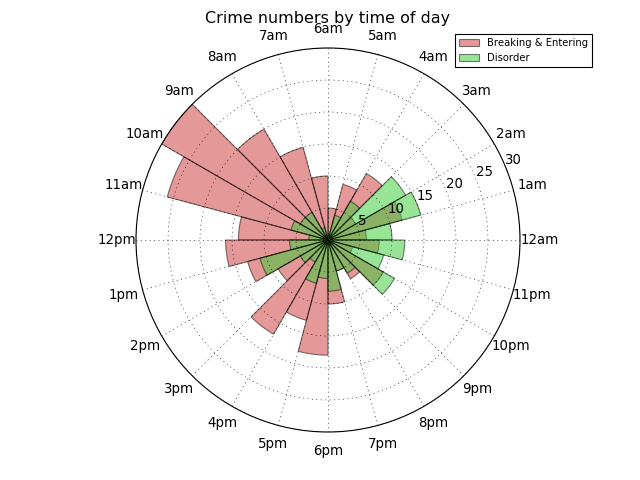

In [39]:
crimeCountTime('Breaking & Entering', 'Disorder')

In [70]:
## Let's do a PCA on a re-arranging of the data that has counts separated into bins
## "time of day" and "day of week".  We can try different temporal divisions.  Perhaps 4-hour
## blocks. 
import itertools as it
import copy

Y=np.zeros( (numdays, len(ctypes), 7, 6), dtype=np.float32 )
for x in bigList:
    if 'Date/Time' in x:
        Y[ (x['Date']-sorteddates[0]).days, ctypelist.index(x['Crime Type']), 
          x['Date'].weekday(), x['Date/Time'].hour//4] += 1.0
avg = sum([Y[i] for i in range(numdays)])/numdays
for i in range(numdays):
    Y[i] -= avg
Y = np.reshape( Y, (numdays, len(ctypes)*7*6) )
pca = PCA(n_components=len(ctypes)*7*6)
pca.fit(Y)
print(pca.explained_variance_)

pcaout = np.reshape(pca.components_, (numdays, len(ctypes), 7, 6))
Lpcaout = pcaout.tolist()

sixHP = ['12am--4am', '4am--8am', '8am--12pm', '12pm--4pm', '4pm--8pm', '8pm--12pm']

def interpPCA(i):
    w = copy.deepcopy(Lpcaout[i])
    for j,k,l in it.product(range(len(ctypes)), range(7), range(6)):
        w[j][k][l] = [w[j][k][l], ctypes[j], weekNames[k], sixHP[l], (j,k,l)]
    wsrt = []
    for j,k,l in it.product(range(len(ctypes)), range(7), range(6)):
        newit = list(w[j][k][l])
        newit[0] = abs(newit[0])
        wsrt.append(newit)
        
    wSrt = sorted(wsrt, key=operator.itemgetter(0), reverse=True )

    ## let's build the return value from the original data, but sorted. 
    retval = [ w[x[4][0]][x[4][1]][x[4][2]][0:4] for x in wSrt]
    ## flatten to a 1-dimensional list of 4-tuples
    return retval

## let's write some code that looks for trade offs and strong positive 
## correllations. 

def summarize(i):
    dat = interpPCA(i)
    ## let's take the items whose absolute values range between the max and half the
    ## max value
    mval = abs(dat[0][0])
    plist = []; mlist = [];
    print("At level ", i, " of the PCA decomposition")
    for x in dat:
        if 2*abs(x[0]) > abs(mval):
            if x[0]>0.0: plist.append(x)
            else: mlist.append(x)
    if len(plist)==0 or len(mlist)==0:
        print("All items correllated: ")
        for x in it.chain(plist, mlist):
            print(" {:>10} {:>10} {:>10} ".format(x[2],x[3],x[1]), " mag == ", x[0])
    else:
        print("There is a trade-off between: ")
        for x in plist:
            print(" {:>10} {:>10} {:>10} ".format(x[2],x[3],x[1]), " mag == ", x[0])
        print("and")
        for x in mlist:
            print(" {:>10} {:>10} {:>10} ".format(x[2],x[3],x[1]), " mag == ", x[0])
    print("\n")
    

summarize(1)
## plist and mlist items are 4-element lists:
## [pca value, Crime Type, Date string, time range]
## cutden is a positive integer, determines how far we go before we start
## discounting elements of the PCA. cutden=2 means we go to terms 1/2 the 
## magnitude of the largest term, cutden=3 to 1/3, etc. 
def plotsummary(i, cutden=2):
    hbounds = {'12am--4am' : (0,4), '4am--8am' : (4,8), '8am--12pm' : (8,12), 
               '12pm--4pm' : (12, 16), '4pm--8pm' : (16,20), '8pm--12pm' : (20,24) }
    dat = interpPCA(i)
    mval = abs(dat[0][0])
    plist = []; mlist = [];
    for x in dat:
        if cutden*abs(x[0]) > abs(mval):
            if x[0]>0.0: plist.append(x)
            else: mlist.append(x)
    ## now let's run through the week-by-week data and assemble a bar plot. 
    arr1 = np.zeros( 1 + numdays//7 )
    arr2 = np.zeros( 1 + numdays//7 )
    ## let's run through the bigList just once, and the mlist, plist many times...
    for x in bigList:
        if 'Date/Time' in x:
            ## now let's check to see if this item satisfies a criterion from plist or mlist
            for y in plist:
                if x['Crime Type'] == y[1] and x['Date'].weekday()==weekNames.index(y[2]) and \
                   x['Date/Time'].hour >= hbounds[y[3]][0] and \
                   x['Date/Time'].hour <= hbounds[y[3]][1]:
                    arr1[(x['Date']-sorteddates[0]).days//7] += 1
            for y in mlist:
                if x['Crime Type'] == y[1] and x['Date'].weekday()==weekNames.index(y[2]) and \
                   x['Date/Time'].hour >= hbounds[y[3]][0] and \
                   x['Date/Time'].hour <= hbounds[y[3]][1]:
                    arr2[(x['Date']-sorteddates[0]).days//7] += 1
    avg1 = sum(arr1)/len(arr1)
    avg2 = sum(arr2)/len(arr2)
    arr1 = arr1 - avg1
    arr2 = arr2 - avg2
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    bar1 = ax.bar(np.arange(len(arr1)), arr1, color='b', alpha=0.4)
    bar2 = ax.bar(np.arange(len(arr2)), arr2, color='r', alpha=0.4)
    plt.title("Level "+str(i)+" PCA")
    ax.set_xlabel('weeks')
    ax.set_ylabel('sum of crimes that week minus average')
    tt1 = [[y[2], y[1], y[3]] for y in plist]
    tt2 = [[y[2], y[1], y[3]] for y in mlist]
    t1 = [" ".join(x) for x in tt1]
    t2 = [" ".join(x) for x in tt2]
    t1 = "\n".join(t1)
    t2 = "\n".join(t2)
    ax.legend([bar1,bar2], [t1, t2], 
          prop={'size':9}, bbox_to_anchor=(1.0,0.99))
    plt.show()

[  9.96212292e+00   9.16817570e+00   8.47196484e+00   7.63985109e+00
   7.16403723e+00   6.62714434e+00   1.53311706e+00   1.17586148e+00
   9.65363503e-01   8.97897661e-01   8.58739972e-01   8.38853359e-01
   8.33299756e-01   8.30885589e-01   7.10014820e-01   7.05361962e-01
   6.98952079e-01   6.89813912e-01   6.81044757e-01   6.63403690e-01
   6.47746205e-01   6.41090989e-01   6.36108339e-01   6.16218984e-01
   5.86971164e-01   5.78119636e-01   5.69128871e-01   5.59913754e-01
   5.59411764e-01   5.56283116e-01   5.47561884e-01   5.43698192e-01
   5.38574100e-01   5.18348157e-01   5.11938035e-01   4.89511967e-01
   4.87953186e-01   4.82516915e-01   4.79151875e-01   4.75762993e-01
   4.70095664e-01   4.55325752e-01   4.49959010e-01   4.29832160e-01
   4.21195567e-01   4.19468462e-01   4.15980577e-01   4.12743747e-01
   4.02291536e-01   3.97203445e-01   3.96634072e-01   3.94581228e-01
   3.50299388e-01   3.46234292e-01   3.28664780e-01   3.27698708e-01
   3.25811327e-01   3.23588490e-01

<IPython.core.display.Javascript object>


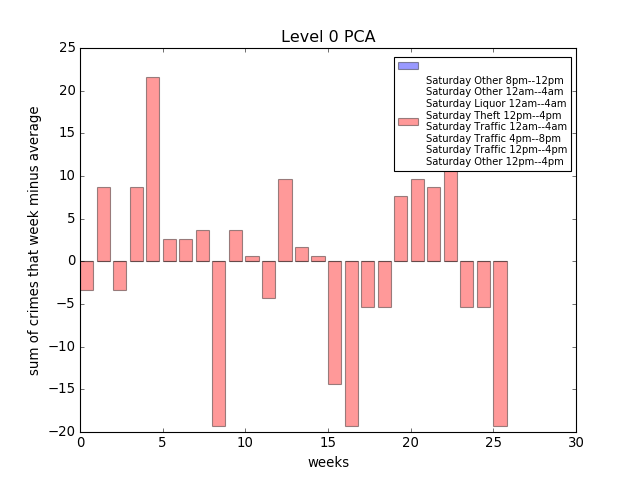

<IPython.core.display.Javascript object>


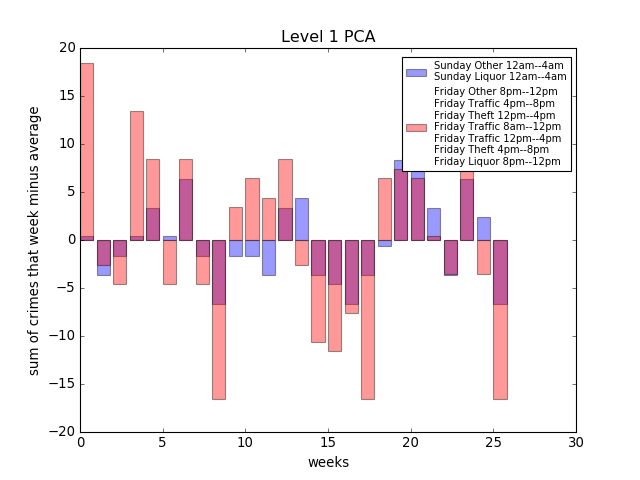

<IPython.core.display.Javascript object>


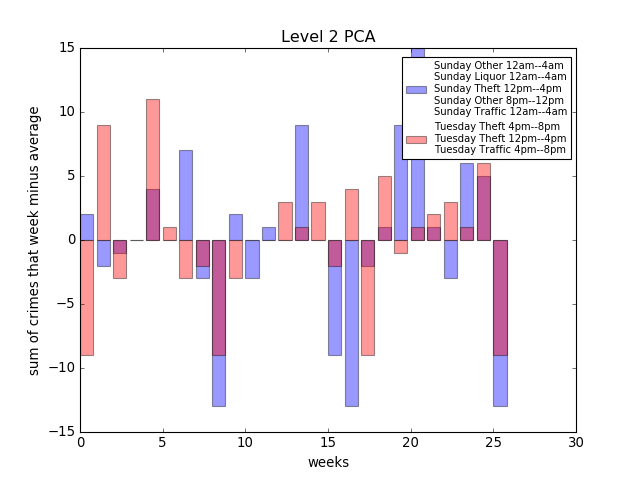

<IPython.core.display.Javascript object>


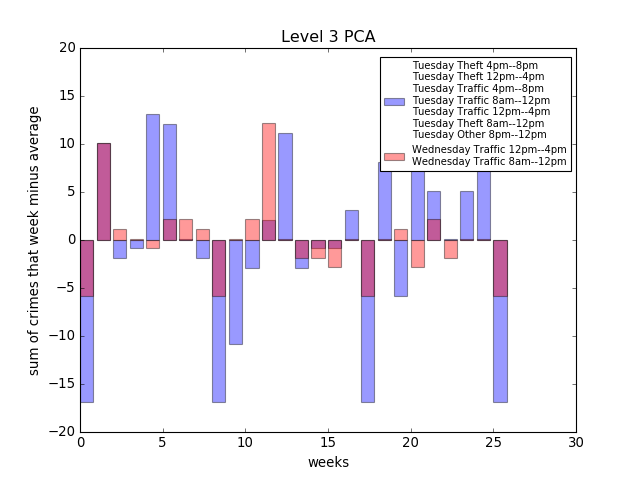

<IPython.core.display.Javascript object>


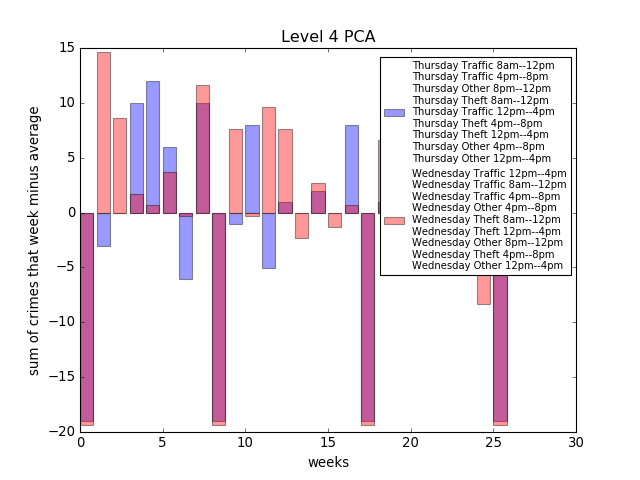

<IPython.core.display.Javascript object>


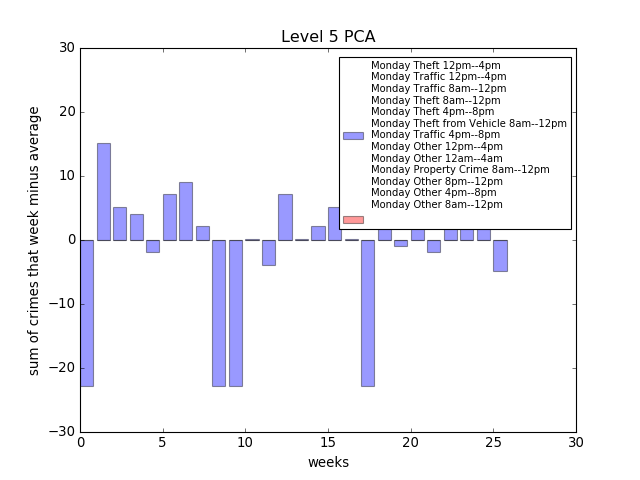

/usr/local/lib/python3.4/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


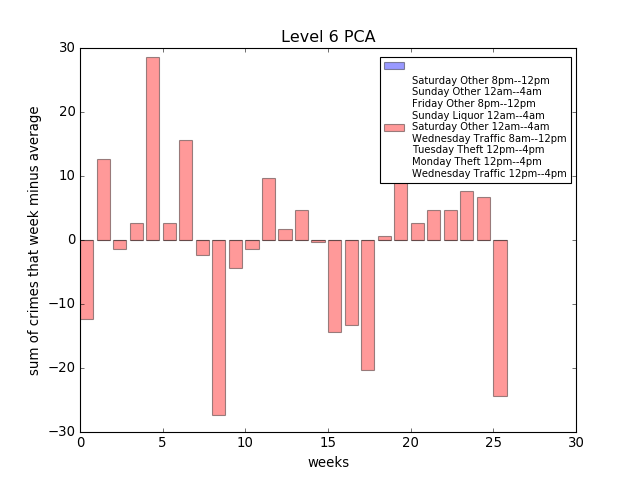

<IPython.core.display.Javascript object>


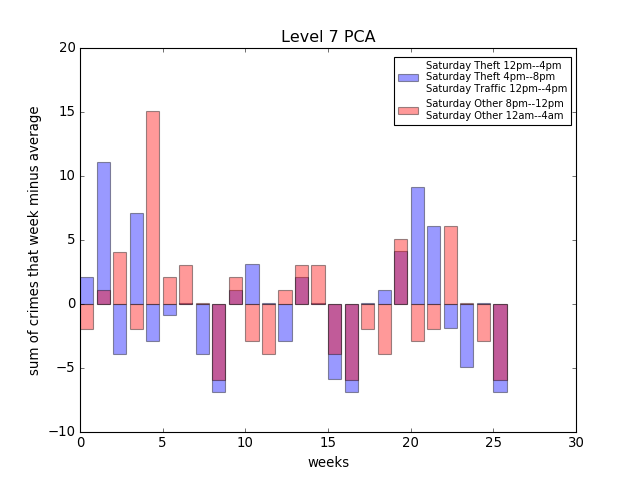

<IPython.core.display.Javascript object>


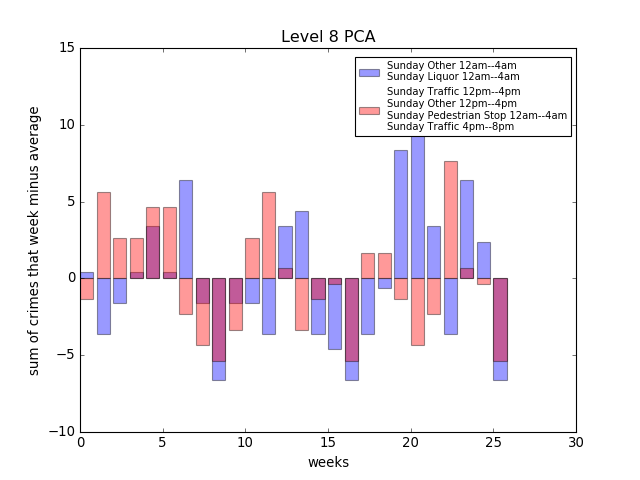

<IPython.core.display.Javascript object>


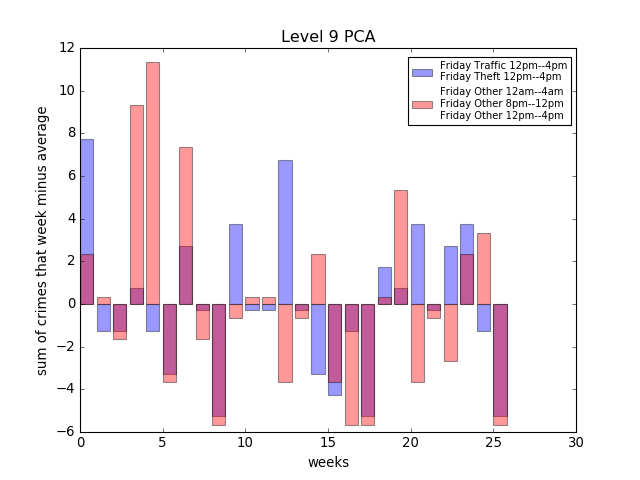

In [72]:
## range 0 through 5 of the PCA seem to be clearly dominant.  The remainder are relatively
## small potatoes.
for i in range(10):
    plotsummary(i,2)

/usr/local/lib/python3.4/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


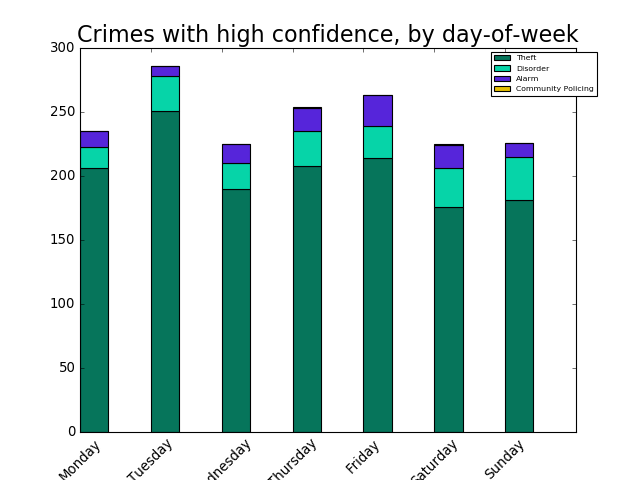

In [73]:
## Let's separate the crime types by the ones that largely are reported when they
## happen, vs. ones that depend on police presence.  I'm thinking of things where the
## evidence is so strong there's no reason not to report it.  This is my own personal
## bias but it will ?hopefully? help... 

rctypes = []
rctypes.append(ctypes[0])
rctypes.append(ctypes[1])
rctypes.append(ctypes[8])
rctypes.append(ctypes[16])

colarr = dict([(x, np.random.rand(3,1)) for x in rctypes])

fig = plt.figure() ## get the figure-object for our plot.
width = 0.4
xc = list(range(len(weekNames)))
p = [] ## plot array
psum = np.zeros( len(weekNames) ) ## partial sums for bottom of bars

for i in rctypes:
    p.append( plt.bar(xc, darrcount[i].tolist(), width, color=colarr[i], bottom=psum.tolist()) )
    ## update psum
    for k in range(len(psum)):
        psum[k] += darrcount[i][k]
    
ax1 = plt.subplot(111)
plt.xticks(xc, weekNames, rotation=45)
plt.title('Crimes with high confidence, by day-of-week', fontsize=20)
ax1.legend(p, rctypes, prop={'size':7}, bbox_to_anchor=(1.05,1.0))
        
plt.show()

## interesting.  the crimes where the evidence is fairly clear, these appear to be
## inversely corellated with the "sought-out" type crimes, where police presence 
## is fundamental. 

In [74]:
## Temperature vs. Crime Counts analysis from Stanhope and Aulenback's work. 

import csv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Import hourly weather csv to 2d list. Data from climate.weather.gc.ca
# Date and Time stored in column 0, Temperature in degrees celcius stored in column 6.
# Note that a few date entries have no associated data (i.e no commas after the date)
weather = list(csv.reader(open("victoria-hourly-09012015-03232015.csv")))

# Cleanup the CSV file
for row in range(1,len(weather)):
    
    # Fill in incomplete rows with -1000 to signify invalid entry and create rectangular list.
    if(len(weather[row]) < 25):
        for i in range(len(weather[row]), 25):
                weather[row].append(-1000)
                
    # Convert date and temperature columns to datetime objects and floats.
    weather[row][0] = datetime.strptime(weather[row][0], "%Y-%m-%d %H:%M")
    weather[row][6] = float(weather[row][6])

In [75]:
# Create a numpy array of how common each integer valued temperature was.
# Used for scaling purposes
# All temperatures in the data set ranged between 0°C and 20°C
tempFreq = np.zeros(21)
for row in range(1,len(weather)):
    if(weather[row][6] > -1000):
        tempFreq[round(weather[row][6])] += 1

# Bin each crime into one of 21 possible temperature values.
crimeTemps = np.zeros(21)    
for x in bigList:
    if("Date/Time" in x):
        crimeTime = x["Date/Time"].replace(minute=0)
        for y in range(1,len(weather)):
            if ((crimeTime == weather[y][0]) & (weather[y][6] > -1000)):
                crimeTemps[round(weather[y][6])] += 1



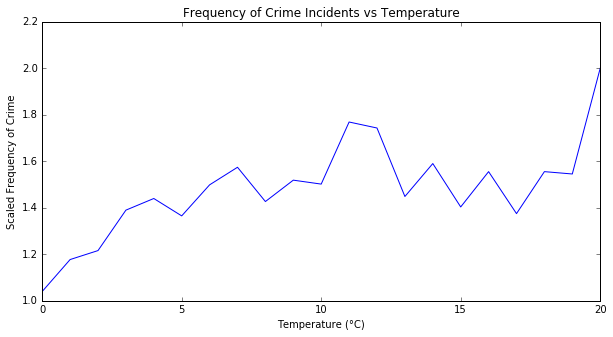

In [76]:
# Plot the count of each crime scaled by the frequency of 
# occurrence of the temperature value.
plt.figure(figsize=(10,5))
plt.plot(crimeTemps/tempFreq)
plt.xlabel('Temperature (°C)')
plt.ylabel('Scaled Frequency of Crime')
plt.title('Frequency of Crime Incidents vs Temperature')
plt.show()